In [1]:
# ========================
# Standard Library
# ========================
import os
import random
import itertools
import math
import copy
from copy import deepcopy
from collections import defaultdict
from typing import Dict, List, Tuple, Optional, Mapping, Sequence

from    scipy.stats         import  boxcox
from pathlib import Path
from dataclasses import dataclass


# ========================
# Core Scientific Stack
# ========================
import numpy as np
import pandas as pd
from pandas.api.types import CategoricalDtype
from scipy import stats
from scipy.special import boxcox as sp_boxcox

# ========================
# Machine Learning Utilities
# ========================
from sklearn.model_selection import train_test_split

# ========================
# Deep Learning (PyTorch)
# ========================
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch import autograd
from torch.utils.data import DataLoader, TensorDataset
import  torch.utils.data    as  utils
from torch.optim import Adam
from torch.cuda.amp import autocast, GradScaler
from torch.amp import GradScaler  # <-- add this import at the top of file

# ========================
# Visualization
# ========================
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def seed_all(seed: int = 42, deterministic: bool = True) -> None:
    import os, random, numpy as np, torch

    # Python built-ins
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)

    # NumPy
    np.random.seed(seed)

    # PyTorch
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

    # cuDNN settings
    torch.backends.cudnn.deterministic = deterministic
    torch.backends.cudnn.benchmark = not deterministic

    if torch.cuda.is_available():
        torch.backends.cuda.matmul.allow_tf32 = False
        torch.backends.cudnn.allow_tf32 = False

In [3]:
seed_all()

# === Categorical Mapping Utilities (simple & tidy) ===
BINCAT_STR2INT = {
    "Gender": {"Male": 0, "Female": 1},
    "Ethnic": {"Asian": 0, "African": 1, "Caucasian": 2, "Other": 3},
    "Base Drug Combo": {
        "FTC + TDF": 0, "3TC + ABC": 1, "FTC + TAF": 2,
        "DRV + FTC + TDF": 3, "FTC + RTVB + TDF": 4, "Other": 5
    },
    "Extra PI": {"DRV": 0, "RTVB": 1, "LPV": 2, "RTV": 3, "ATV": 4, "Not Applied": 5},
    "Extra pk-En": {"False": 0, "True": 1},   # ← fixed typo
}

BINCAT_INT2STR = {
    "Gender": {0: "Male", 1: "Female"},
    "Ethnic": {0: "Asian", 1: "African", 2: "Caucasian", 3: "Other"},
    "Base Drug Combo": {
        0: "FTC + TDF", 1: "3TC + ABC", 2: "FTC + TAF",
        3: "DRV + FTC + TDF", 4: "FTC + RTVB + TDF", 5: "Other"
    },
    "Extra PI": {0: "DRV", 1: "RTVB", 2: "LPV", 3: "RTV", 4: "ATV", 5: "Not Applied"},
    "Extra pk-En": {0: "False", 1: "True"},   # ← fixed typo
}

def BinCat2Num(df: pd.DataFrame, allow_already_int: bool = True) -> pd.DataFrame:
    """
    Map categorical string columns → integer codes (0..K-1).
    If allow_already_int=True, columns already coded as ints in the valid range are left as-is.
    """
    out = df.copy()
    for col, mapping in BINCAT_STR2INT.items():
        if col not in out.columns:
            continue
        s = out[col]
        if allow_already_int and pd.api.types.is_integer_dtype(s):
            # Validate codes are within allowed range
            allowed = set(mapping.values())
            bad = set(pd.Series(s.dropna().unique(), dtype=int)) - allowed
            if bad:
                raise ValueError(f"Unexpected integer codes in '{col}': {sorted(bad)}")
            continue
        mapped = s.map(mapping)
        if mapped.isnull().any():
            bad_vals = s[mapped.isnull()].unique()
            raise ValueError(f"Unmapped values in column '{col}': {bad_vals}")
        out[col] = mapped.astype(int)
    return out

def BinCat2Str(df: pd.DataFrame) -> pd.DataFrame:
    """Map categorical integer codes → string labels."""
    out = df.copy()
    for col, mapping in BINCAT_INT2STR.items():
        if col in out.columns:
            out[col] = out[col].map(mapping)
    return out

In [4]:
seed_all()

# ========================
# Fit Box–Cox parameters
# ========================
def compute_boxcox_params(
    df: pd.DataFrame,
    columns: List[str] = ("VL", "CD4"),
    eps: float = 1e-3,
) -> Dict[str, dict]:
    """
    Fit Box–Cox λ per column on (x + eps), and store min/range of the
    transformed values for later [0,1] scaling.
    """
    params: Dict[str, dict] = {}
    for col in columns:
        x = df[col].dropna().astype(float).to_numpy()
        x = x + eps  # ensure positivity

        # Handle empty/degenerate columns safely
        if x.size == 0 or not np.all(np.isfinite(x)) or np.min(x) <= 0 or np.ptp(x) == 0:
            params[col] = {"lambda": 1.0, "min": 0.0, "range": 1.0, "eps": eps}
            continue

        bc, lam = stats.boxcox(x)  # returns transformed values + MLE λ
        bc_min = float(np.min(bc))
        bc_rng = float(np.max(bc) - bc_min) or 1.0  # avoid zero range

        params[col] = {"lambda": float(lam), "min": bc_min, "range": bc_rng, "eps": eps}
    return params


# ========================
# Box–Cox + Min–Max → [0,1]
# ========================
def apply_boxcox_minmax_transform(
    df: pd.DataFrame,
    params: Dict[str, dict],
    columns: List[str] = ("VL", "CD4"),
) -> pd.DataFrame:
    """
    Apply Box–Cox with fitted λ, then scale to [0,1] via stored min/range.
    NaNs are preserved.
    """
    out = df.copy()
    for col in columns:
        if col not in out.columns:
            continue
        p = params[col]
        mask = out[col].notna().to_numpy()
        if not mask.any():
            continue

        x = out.loc[mask, col].astype(float).to_numpy() + p["eps"]
        bc = sp_boxcox(x, p["lambda"])  # fixed-λ forward transform
        scaled = (bc - p["min"]) / p["range"]
        out.loc[mask, col] = scaled
    return out


# ========================
# Inverse Box–Cox (Torch)
# ========================
def inverse_boxcox_torch(bc: torch.Tensor, lmbda: float, eps: float = 1e-3) -> torch.Tensor:
    """
    Invert Box–Cox (on Box–Coxed values) to original x (minus eps shift).
    """
    if lmbda == 0.0:
        return torch.exp(bc) - eps
    base = torch.clamp(lmbda * bc + 1.0, min=1e-12)  # numeric safety
    return torch.pow(base, 1.0 / lmbda) - eps


# ========================
# Back-transform features
# ========================
def backtransform_art_tensor(
    tensor: torch.Tensor,
    feature_names: List[str],
    transform_params: Dict[str, dict],
    real_columns: List[str] = ("VL", "CD4"),
) -> pd.DataFrame:
    """
    Expects `tensor` with real cols in scaled Box–Cox space ([0,1]).
    Steps: unscale to Box–Cox → inverse Box–Cox → subtract eps.
    """
    x = tensor.detach().clone()
    idx_map = {n: i for i, n in enumerate(feature_names)}

    for col in real_columns:
        if col not in idx_map:
            continue
        i = idx_map[col]
        p = transform_params[col]
        bc = x[:, i] * p["range"] + p["min"]
        x[:, i] = inverse_boxcox_torch(bc, p["lambda"], p["eps"])

    return pd.DataFrame(x.cpu().numpy(), columns=feature_names)

In [5]:
seed_all()

# === Load and Preprocess Raw Data ===
raw_url = "https://figshare.com/ndownloader/files/40584980"
DROP_COLS = ["VL (M)", "CD4 (M)", "Drug (M)"]

# 1) Read only the columns we need
_all_cols = pd.read_csv(raw_url, nrows=0).columns.tolist()
usecols = [c for c in _all_cols if c not in DROP_COLS]
All_Data = pd.read_csv(raw_url, usecols=usecols)

# 2) Map numeric codes -> human-readable labels (with typo fixed)
NUM2STR = {
    "Gender":          {1: "Male", 2: "Female"},
    "Ethnic":          {1: "Asian", 2: "African", 3: "Caucasian", 4: "Other"},
    "Base Drug Combo": {
        0: "FTC + TDF", 1: "3TC + ABC", 2: "FTC + TAF",
        3: "DRV + FTC + TDF", 4: "FTC + RTVB + TDF", 5: "Other"
    },
    "Comp. INI":       {0: "DTG", 1: "RAL", 2: "EVG", 3: "Not Applied"},
    "Comp. NNRTI":     {0: "NVP", 1: "EFV", 2: "RPV", 3: "Not Applied"},
    "Extra PI":        {0: "DRV", 1: "RTVB", 2: "LPV", 3: "RTV", 4: "ATV", 5: "Not Applied"},
    "Extra pk-En":     {0: "False", 1: "True"},   # <-- fixed typo
}

for col, mapping in NUM2STR.items():
    if col in All_Data.columns:
        mapped = All_Data[col].map(mapping)
        if mapped.isnull().any():
            bad = All_Data.loc[mapped.isnull(), col].unique()
            raise ValueError(f"Unmapped codes in '{col}': {bad}")
        All_Data[col] = mapped.astype("category")

for cont in ("VL", "CD4"):
    if cont in All_Data.columns:
        All_Data[cont] = pd.to_numeric(All_Data[cont], errors="coerce")

In [6]:
seed_all()

# === Create smaller demo dataset for collaborators ===
SEL_COLS = [
    "VL", "CD4", "Gender", "Ethnic", "Base Drug Combo",
    "Extra PI", "Extra pk-En", "PatientID", "Timestep"
]

# Filter by PatientID, select only wanted columns, reset index
Sub_Data = (
    All_Data.loc[All_Data["PatientID"] < 300, SEL_COLS]
            .reset_index(drop=True)
)

missing = set(SEL_COLS) - set(All_Data.columns)
if missing:
    raise KeyError(f"Missing expected columns in All_Data: {missing}")


In [7]:
seed_all()
# --- Canonical column names for downstream ---
REAL_COLS = ["VL", "CD4"]
CAT_SIZES = {
    "Gender": 2,
    "Ethnic": 4,
    "Base_Drug_Combo": 6,
    "Extra_PI": 6,
    "Extra_pk_En": 2,
}

# Embedding sizes policy
EMB_SIZE_FOR = {
    "real": lambda k: 1,     # passthrough
    "bin":  lambda k: 2,     # small embedding for binary
    "cat":  lambda k: 4,     # fixed 4-dim for multiclass
}

def build_dtype(real_cols, cat_sizes, emb_policy=EMB_SIZE_FOR, start_idx=0):
    rows = []
    idx = start_idx
    i = 0

    # Reals
    for name in real_cols:
        k = 1
        emb = emb_policy["real"](k)
        rows.append([i, name, "real", k, emb, idx, idx + k])
        idx += k; i += 1

    # Categorical (emit num_classes one-hot dims)
    for name, k in cat_sizes.items():
        ftype = "bin" if k == 2 else "cat"
        emb = emb_policy[ftype](k)
        rows.append([i, name, ftype, k, emb, idx, idx + k])
        idx += k; i += 1

    dtype = pd.DataFrame(rows, columns=[
        "index", "name", "type", "num_classes",
        "embedding_size", "index_start", "index_end"
    ])
    return dtype

def validate_dtype(dtype: pd.DataFrame, expected_total=None):
    d = dtype.sort_values("index").reset_index(drop=True)
    # contiguous spans
    starts = d["index_start"].to_numpy()
    ends   = d["index_end"].to_numpy()
    assert np.all(starts[1:] == ends[:-1]), "Spans must be contiguous"
    # monotonic & positive widths
    assert np.all(ends > starts), "Each span must have positive width"
    # total width
    total = int(ends[-1])
    if expected_total is not None:
        assert total == expected_total, f"Total dims {total} != expected {expected_total}"
    return total

def expand_feature_names(dtype: pd.DataFrame):
    names = []
    for _, r in dtype.iterrows():
        if r["type"] == "real":
            names.append(r["name"])
        else:
            k = int(r["num_classes"])
            names.extend([f"{r['name']}_{j}" for j in range(k)])
    return names

# ---- Building schema ----
dtype = build_dtype(REAL_COLS, CAT_SIZES)
TOTAL_DIM = validate_dtype(dtype)
FEATURE_NAMES = expand_feature_names(dtype)
assert len(FEATURE_NAMES) == TOTAL_DIM




In [8]:
seed_all()

Sub_Data = BinCat2Num(Sub_Data)

# 2) Rename once so columns match  dtype/schema (snake_case)
NAME_MAP = {
    "Base Drug Combo": "Base_Drug_Combo",
    "Extra PI":        "Extra_PI",
    "Extra pk-En":     "Extra_pk_En",
}
Sub_Data = Sub_Data.rename(columns=NAME_MAP)

In [9]:
###===###
seed_all()

def _collect_schema(dtype: pd.DataFrame) -> tuple[list[str], dict]:
    """Return (real_cols, cat_spec) from dtype manifest."""
    real_cols: list[str] = []
    cat_spec: dict[str, int] = {}
    for _, r in dtype.iterrows():
        if r["type"] == "real":
            real_cols.append(r["name"])
        else:
            cat_spec[r["name"]] = int(r["num_classes"])
    return real_cols, cat_spec


def _one_hot_numpy(int_codes: np.ndarray, num_classes: int) -> np.ndarray:
    """Fast one-hot using NumPy indexing; shape: [N, num_classes]."""
    return np.eye(num_classes, dtype=np.float32)[int_codes]


def ExecuteB002(
    My_df: pd.DataFrame,
    dtype: pd.DataFrame,
    Hyper005_BatchSize: int,
    *,
    seq_len: int = 60,
    feature_names: Optional[list[str]] = None,
    transform_params: Optional[dict] = None,   # from compute_boxcox_params (preferred)
    use_legacy_scaling: bool = False,          # fallback to old VL/CD4 scheme if True
) -> tuple[np.ndarray, torch.utils.data.DataLoader, torch.Tensor]:
    """
    Build a 3D design tensor [N_patients, L, D] from a flat dataframe using `dtype`
    as the authoritative schema, then return (numpy_copy, DataLoader, flat_train_tensor).

    Assumptions:
      - My_df already has integer-coded categoricals (via BinCat2Num) and snake_case names.
      - If `transform_params` is given, VL/CD4 are scaled using Box–Cox->[0,1] from params.
        Otherwise, if `use_legacy_scaling=True`, fall back to the original constants.

    Returns:
      - data_np: np.ndarray of shape [N, L, D]
      - trn_loader: DataLoader over TensorDataset((X), (lengths))
      - All_Trainable_Data: torch.FloatTensor of shape [N*L, D]
    """
    # --- 0) Schema & sizes ---
    total_dim: int = int(dtype["index_end"].max())
    real_cols, cat_spec = _collect_schema(dtype)

    # Optional: expand names once, only for robust checks
    if feature_names is None:
        feature_names = []
        for _, r in dtype.iterrows():
            if r["type"] == "real":
                feature_names.append(r["name"])
            else:
                k = int(r["num_classes"])
                feature_names.extend([f"{r['name']}_{j}" for j in range(k)])
    assert len(feature_names) == total_dim, "FEATURE_NAMES length must equal TOTAL_DIM"

    # --- 1) Input hygiene & shape accounting ---
    # Ensure required columns exist
    needed_cols = set(real_cols) | set(cat_spec.keys())
    missing = needed_cols - set(My_df.columns)
    if missing:
        raise KeyError(f"Missing columns for design matrix: {sorted(missing)}")

    # How many rows and patients? We assume flat [N*L] rows and reshape to [-1, L, D].
    n_rows = len(My_df)
    if n_rows % seq_len != 0:
        raise ValueError(f"Row count {n_rows} is not divisible by seq_len={seq_len}. "
                         f"Please align or pad/truncate.")
    n_patients = n_rows // seq_len

    # --- 2) Allocate and fill the design matrix in one pass ---
    X = np.zeros((n_rows, total_dim), dtype=np.float32)

    # 2a) Real columns (as float32)
    for _, r in dtype.iterrows():
        if r["type"] != "real":
            continue
        col = r["name"]
        i0, i1 = int(r["index_start"]), int(r["index_end"])
        x = pd.to_numeric(My_df[col], errors="coerce").astype(np.float32).to_numpy()
        # Forward transforms:
        if transform_params is not None:
            # (Assumes My_df[col] is in raw units; apply Box–Cox -> [0,1])
            p = transform_params[col]
            x_bc = stats.boxcox(x + p["eps"], p["lambda"])  # fixed-λ forward
            x = (x_bc - p["min"]) / (p["range"] if p["range"] != 0 else 1.0)
        elif use_legacy_scaling:
            # Legacy scheme from the original code
            if col == "VL":
                x = x.copy()
                x[x >= 100000] = 100000
                x = stats.boxcox(x + 1.0, -0.11862349303078497)
                x = x / 6.278682
            elif col == "CD4":
                x = np.log(x + 1.0)
                x = x / 13.311331132544721
        # else: pass-through (already pre-scaled upstream)
        X[:, i0:i1] = x.reshape(-1, 1)

    # 2b) Categorical blocks (strict one-hot using known class counts & column order)
    for _, r in dtype.iterrows():
        if r["type"] == "real":
            continue
        name = r["name"]
        k = int(r["num_classes"])
        i0, i1 = int(r["index_start"]), int(r["index_end"])
        codes = pd.to_numeric(My_df[name], errors="raise").astype("int64").to_numpy()
        # Validate codes are within range [0, k-1]
        min_c, max_c = codes.min(), codes.max()
        if min_c < 0 or max_c >= k:
            raise ValueError(f"Column '{name}' has codes outside [0,{k-1}]: "
                             f"observed [{min_c},{max_c}]")
        X[:, i0:i1] = _one_hot_numpy(codes, k)

    # --- 3) Reshape to [N, L, D] ---
    X3 = X.reshape(n_patients, seq_len, total_dim)

    # --- 4) Torch dataset/loader (no extra deep copies) ---
    X_tensor = torch.from_numpy(X3).float()             # [N, L, D]
    lengths  = torch.full((n_patients, 1, 1), seq_len)  # keep original shape contract

    ds = TensorDataset(X_tensor, lengths)
    trn_loader = DataLoader(ds, batch_size=Hyper005_BatchSize, shuffle=True, drop_last=True)

    # --- 5) Flat trainable tensor [N*L, D] without looping over the loader ---
    All_Trainable_Data = X_tensor.reshape(-1, total_dim).contiguous()

    # Return a NumPy copy in case downstream plotting expects ndarray
    data_np = X3.copy()
    return data_np, trn_loader, All_Trainable_Data


In [10]:
seed_all()

# -----------------------------
# 1) Time embedding (sinusoidal)
# -----------------------------
def build_sinusoidal_table(n_steps: int, dim: int, device=None) -> torch.Tensor:
    """Non-trainable sinusoidal embeddings [n_steps, dim]."""
    pe = torch.zeros(n_steps, dim, device=device)
    position = torch.arange(0, n_steps, dtype=torch.float32, device=device).unsqueeze(1)
    div_term = torch.exp(torch.arange(0, dim, 2, device=device, dtype=torch.float32) *
                         (-math.log(10000.0) / dim))
    pe[:, 0::2] = torch.sin(position * div_term)
    pe[:, 1::2] = torch.cos(position * div_term)
    return pe


class TimeEmbedding(nn.Module):
    """t -> embedding -> FiLM (scale, shift)."""
    def __init__(self, n_steps: int, dim: int, out_channels: int):
        super().__init__()
        self.table = nn.Embedding(n_steps, dim)
        with torch.no_grad():
            self.table.weight.copy_(build_sinusoidal_table(n_steps, dim))
        self.table.weight.requires_grad_(False)  # fixed sinusoidal
        # small MLP to map time embedding -> FiLM params
        self.mlp = nn.Sequential(
            nn.Linear(dim, out_channels * 2),
            nn.SiLU(),
            nn.Linear(out_channels * 2, out_channels * 2)
        )

    def forward(self, t: torch.Tensor) -> tuple[torch.Tensor, torch.Tensor]:
        """
        Returns (gamma, beta) with shape [B, C] for FiLM conditioning.
        """
        h = self.table(t)          # [B, dim]
        h = self.mlp(h)            # [B, 2C]
        gamma, beta = torch.chunk(h, 2, dim=-1)
        return gamma, beta


# -----------------------------
# 2) Residual 1D conv block
# -----------------------------
class ResBlock1D(nn.Module):
    def __init__(self, channels: int, kernel_size: int = 3, groups: int = 8, dropout: float = 0.0):
        super().__init__()
        padding = kernel_size // 2
        g = max(1, min(groups, channels))  # clamp groups
        self.norm1 = nn.GroupNorm(g, channels)
        self.conv1 = nn.Conv1d(channels, channels, kernel_size, padding=padding)
        self.norm2 = nn.GroupNorm(g, channels)
        self.conv2 = nn.Conv1d(channels, channels, kernel_size, padding=padding)
        self.act   = nn.SiLU()
        self.dropout = nn.Dropout(dropout) if dropout > 0 else nn.Identity()

    def forward(self, x: torch.Tensor, gamma: torch.Tensor | None = None, beta: torch.Tensor | None = None):
        """
        x: [B, C, L]; gamma/beta: [B, C] (FiLM).
        """
        residual = x
        y = self.norm1(x)
        if gamma is not None and beta is not None:
            # FiLM: per-channel scale/shift
            y = y * (1 + gamma.unsqueeze(-1)) + beta.unsqueeze(-1)
        y = self.act(y)
        y = self.conv1(y)

        y = self.norm2(y)
        y = self.act(y)
        y = self.dropout(y)
        y = self.conv2(y)

        return y + residual


# -----------------------------
# 3) U-Net (1D over time)
# -----------------------------
class MyUNet(nn.Module):
    """
    Clean 1D U-Net with FiLM time conditioning.

    Input : x_t [B, 1, Feat_Dim, Len]
    Output: noise_hat with same shape.

    Args:
        Cur_HD:     base channel width (e.g., 128)
        N_Steps:    diffusion steps for time embedding
        Time_Emb_Dim: size of sinusoidal time embedding
        Feat_Dim:   number of features (default 22)
        Len:        sequence length along time (e.g., 100 or 60)
        levels:     number of down/up levels
    """
    def __init__(self,
                 Cur_HD: int,
                 N_Steps: int = 1000,
                 Time_Emb_Dim: int = 128,
                 Feat_Dim: int = 22,
                 Len: int = 100,
                 levels: int = 3):
        super().__init__()
        self.Feat_Dim = Feat_Dim
        self.Len = Len
        C = Cur_HD

        # Pre/post: feature mixing at each time step (per-time linear)
        self.bt1 = nn.Sequential(nn.Linear(Feat_Dim, C), nn.SiLU(), nn.Linear(C, C))
        self.bt2 = nn.Sequential(nn.Linear(C, C), nn.SiLU(), nn.Linear(C, Feat_Dim))

        # Time embedding -> FiLM for each stage (we reuse the same module per stage)
        self.time_emb_down = nn.ModuleList([TimeEmbedding(N_Steps, Time_Emb_Dim, C) for _ in range(levels)])
        self.time_emb_up   = nn.ModuleList([TimeEmbedding(N_Steps, Time_Emb_Dim, C) for _ in range(levels)])
        self.time_emb_mid  = TimeEmbedding(N_Steps, Time_Emb_Dim, C)

        # Down path
        self.down_blocks = nn.ModuleList()
        self.downsample  = nn.ModuleList()
        for _ in range(levels):
            self.down_blocks.append(ResBlock1D(C))
            self.downsample.append(nn.Conv1d(C, C, kernel_size=4, stride=2, padding=1))  # /2

        # Middle
        self.mid_block1 = ResBlock1D(C)
        self.mid_block2 = ResBlock1D(C)

        # Up path
        self.upsample   = nn.ModuleList()
        self.up_blocks  = nn.ModuleList()
        for _ in range(levels):
            self.upsample.append(nn.ConvTranspose1d(C, C, kernel_size=4, stride=2, padding=1))  # x2
            self.up_blocks.append(ResBlock1D(C))

        # Final conv over time back to channel C then bt2 to Feat_Dim
        self.out_conv = nn.Conv1d(C, C, kernel_size=3, padding=1)

    def _to_1d(self, x: torch.Tensor) -> torch.Tensor:
        # [B, 1, Feat, Len] -> [B, Len, Feat] -> bt1 -> [B, Len, C] -> [B, C, Len]
        x = x.squeeze(1).transpose(1, 2)                 # [B, Len, Feat]
        x = self.bt1(x)                                  # [B, Len, C]
        x = x.transpose(1, 2).contiguous()               # [B, C, Len]
        return x

    def _to_2d(self, x: torch.Tensor) -> torch.Tensor:
        # [B, C, Len] -> [B, Len, C] -> bt2 -> [B, Len, Feat] -> [B, 1, Feat, Len]
        x = x.transpose(1, 2).contiguous()               # [B, Len, C]
        x = self.bt2(x)                                  # [B, Len, Feat]
        x = x.transpose(1, 2).unsqueeze(1).contiguous()  # [B, 1, Feat, Len]
        return x

    def forward(self, x_t: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        """
        x_t: [B, 1, Feat_Dim, Len]
        t  : [B] int64 diffusion steps
        """
        B = x_t.size(0)
        x = self._to_1d(x_t)   # [B, C, L]

        # Down
        skip = []
        for i, (block, down) in enumerate(zip(self.down_blocks, self.downsample)):
            gamma, beta = self.time_emb_down[i](t)      # [B, C]
            x = block(x, gamma, beta)                   # [B, C, L]
            skip.append(x)
            x = down(x)                                 # [B, C, L/2]

        # Mid
        g_mid, b_mid = self.time_emb_mid(t)
        x = self.mid_block1(x, g_mid, b_mid)
        x = self.mid_block2(x, g_mid, b_mid)

        # Up
        for i, (up, block) in enumerate(zip(self.upsample, self.up_blocks)):
            x = up(x)                                   # [B, C, L*2]
            # Align length (due to odd L) – crop or pad as needed
            if x.size(-1) > skip[-1].size(-1):
                x = x[..., :skip[-1].size(-1)]
            elif x.size(-1) < skip[-1].size(-1):
                pad = skip[-1].size(-1) - x.size(-1)
                x = F.pad(x, (0, pad))
            x = x + skip.pop()                          # simple skip add
            gamma, beta = self.time_emb_up[i](t)
            x = block(x, gamma, beta)

        x = self.out_conv(x)                            # [B, C, L]
        out = self._to_2d(x)                            # [B, 1, Feat_Dim, Len]
        return out


In [11]:
seed_all()

# -------------------------
# AMP (version-safe imports)
# -------------------------
try:
    # PyTorch >= 2.4
    from torch.amp import GradScaler, autocast
    _NEW_AMP = True
except Exception:
    # PyTorch <= 2.3
    from torch.cuda.amp import GradScaler, autocast
    _NEW_AMP = False


# -------------------------
# utilities
# -------------------------
def correlation(x: torch.Tensor, eps: float = 1e-8) -> torch.Tensor:
    """
    Column-wise correlation of a 2D tensor.
    x: [N, D] (flattened across time if needed)
    """
    x = x - x.mean(dim=0, keepdim=True)
    std = x.norm(dim=0, keepdim=True).clamp_min(eps)
    x = x / std
    return x.t() @ x  # (D,D)


def Recentre_Data(x: torch.Tensor) -> torch.Tensor:
    """Map [0,1] -> [-1,1]."""
    return x.mul(2.0).sub(1.0)


def LoadPreTrain(content = [False, 'U_SD', 0]):
    """
    content = [Continue(bool), ckpt_name(str), epoch_idx(int)]
    Loads './Z002_Parameters/Epoch_XXXX/<ckpt_name>' if Continue=True.
    """
    Continue, name, ep = content
    if not Continue:
        return 0

    folder = Path("./Z002_Parameters") / f"Epoch_{int(ep):04d}"
    ckpt_path = folder / name
    if not ckpt_path.exists():
        raise FileNotFoundError(f"Checkpoint not found: {ckpt_path}")

    # map_location='cpu' so we can .to(device) later
    state = torch.load(str(ckpt_path), map_location="cpu")
    return state


@dataclass
class TrainCfg:
    hd: int
    n_steps: int
    beta_min: float
    beta_max: float
    batch_size: int
    epochs: int
    lr: float
    target_len: int = 100            # pad/truncate length on time axis
    recon_weight: float = 20.0       # λ for reconstruction loss
    grad_clip: float = 1.0           # 0 or None to disable
    use_amp: bool = True             # AMP for speed on CUDA


# -------------------------
# trainer
# -------------------------
class ExecuteB003(nn.Module):
    def __init__(
        self,
        All_Trainable_Data: torch.Tensor,
        Hyper001_HD,
        Hyper002_NSteps, Hyper003_MinBeta, Hyper004_MaxBeta,
        Hyper005_BatchSize, Hyper006_NEpochs,
        Hyper007_LR,
        data_types,
        continue_info = [False, 'U-SD', 0],
    ):
        super().__init__()

        # device
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        # config (retain original signature; wrap as a dataclass internally)
        self.cfg = TrainCfg(
            hd=Hyper001_HD,
            n_steps=Hyper002_NSteps,
            beta_min=Hyper003_MinBeta,
            beta_max=Hyper004_MaxBeta,
            batch_size=Hyper005_BatchSize,
            epochs=Hyper006_NEpochs,
            lr=Hyper007_LR,
            target_len=100,
        )

        # recenter & cache real correlation (if want to add a penalty later)
        atd = Recentre_Data(All_Trainable_Data)  # [N*L, D]
        with torch.no_grad():
            self.correlation_real = correlation(atd).to(self.device)

        # model
        self.UNet = MyUNet(
            Cur_HD=self.cfg.hd,
            N_Steps=self.cfg.n_steps,
            Time_Emb_Dim=128,
            Feat_Dim=22,
            Len=self.cfg.target_len,
        ).to(self.device)

        # (optional) resume
        U_SD = LoadPreTrain(continue_info)
        if U_SD != 0:
            self.UNet.load_state_dict(U_SD, strict=True)
            self.PreviousEpoch = int(continue_info[2])
        else:
            self.PreviousEpoch = 0

        # diffusion schedule as buffers (create ON DEVICE so indexing works)
        betas = torch.linspace(
            self.cfg.beta_min, self.cfg.beta_max, self.cfg.n_steps,
            dtype=torch.float32, device=self.device
        )
        alphas = 1.0 - betas
        alphas_bar = torch.cumprod(alphas, dim=0)
        self.register_buffer("betas", betas)
        self.register_buffer("alphas", alphas)
        self.register_buffer("alphas_bar", alphas_bar)

        # optim & loss
        self.criterion = nn.MSELoss(reduction="none")  # we reduce manually with masks
        self.optimiser = Adam(self.UNet.parameters(), lr=self.cfg.lr, betas=(0.9, 0.999))

        # AMP scaler (version-safe)
        if _NEW_AMP:
            # PyTorch >= 2.4
            self.scaler = GradScaler(
                "cuda" if self.device.type == "cuda" else "cpu",
                enabled=self.cfg.use_amp,
            )
        else:
            # PyTorch <= 2.3
            self.scaler = GradScaler(enabled=(self.cfg.use_amp and self.device.type == "cuda"))

    # ------------- core ops -------------
    def Manual_Forward(self, x_T0: torch.Tensor, Cur_T: torch.Tensor, Cur_Eta: torch.Tensor) -> torch.Tensor:
        """
        x_T0: [B,1,C,T], Cur_T: [B], Cur_Eta: [B,1,C,T]
        """
        a_bar = self.alphas_bar[Cur_T].view(-1, 1, 1, 1)  # [B,1,1,1]
        return a_bar.sqrt() * x_T0 + (1.0 - a_bar).sqrt() * Cur_Eta

    def Network_Backward(self, Fuzzy_X: torch.Tensor, Cur_T: torch.Tensor) -> torch.Tensor:
        return self.UNet(Fuzzy_X, Cur_T)  # expects t=[B]

    def Reconstruct(self, Fuzzy_X, Cur_T, Cur_Eta, Predicted_Eta):
        a_bar = self.alphas_bar[Cur_T].view(-1, 1, 1, 1)
        # blend true+pred noise like original (can set blend=0.0 to disable)
        blend = torch.rand_like(Cur_Eta)
        Pred_Noise = blend * Cur_Eta + (1.0 - blend) * Predicted_Eta
        x0_hat = (Fuzzy_X - (1.0 - a_bar).sqrt() * Pred_Noise) / (a_bar.sqrt() + 1e-8)
        return x0_hat

    # ------------- helpers -------------
    def _pad_time(self, x: torch.Tensor, tgt_len: int) -> tuple[torch.Tensor, torch.Tensor]:
        """
        x: [B,1,C,L]  -> returns (x_padded [B,1,C,tgt_len], mask [B,1,1,tgt_len] with 1=valid)
        """
        B, _, C, L = x.shape
        if L == tgt_len:
            mask = x.new_ones((B, 1, 1, L))
            return x, mask
        if L > tgt_len:
            x = x[..., :tgt_len]
            mask = x.new_ones((B, 1, 1, tgt_len))
            return x, mask
        pad = tgt_len - L
        x = F.pad(x, (0, pad), value=0.0)      # pad time on the right
        mask = torch.cat([x.new_ones((B,1,1,L)), x.new_zeros((B,1,1,pad))], dim=-1)
        return x, mask

    def _masked_mse(self, pred: torch.Tensor, target: torch.Tensor, mask: torch.Tensor) -> torch.Tensor:
        """
        pred/target: [B,1,C,T], mask: [B,1,1,T]
        """
        loss = self.criterion(pred, target)  # [B,1,C,T]
        loss = loss * mask                  # broadcast over C
        denom = mask.sum() * pred.size(2)   # valid elements = sum over T * C
        denom = denom.clamp_min(1.0)
        return loss.sum() / denom

    # ------------- train loop -------------
    def train(self, My_Loader):
        self.UNet.train()

        for e in range(self.cfg.epochs - self.PreviousEpoch):
            tot, l_diff, l_rec = 0.0, 0.0, 0.0

            for Cur_X, lengths in My_Loader:
                # Cur_X: [B, L, D] in [0,1]; lengths shape like (B,1,1) but constant
                B, L, D = Cur_X.shape
                Cur_X = Cur_X.to(self.device).unsqueeze(1).transpose(2, 3)  # -> [B,1,D,L]
                Cur_X = Recentre_Data(Cur_X)

                # pad to target length
                Cur_X_padded, mask = self._pad_time(Cur_X, self.cfg.target_len)

                # sample t and noise
                Cur_T   = torch.randint(0, self.cfg.n_steps, (B,), device=self.device)
                Cur_Eta = torch.randn_like(Cur_X_padded)

                # version-safe autocast
                if _NEW_AMP:
                    ac_kwargs = dict(device_type="cuda", enabled=(self.cfg.use_amp and self.device.type == "cuda"))
                else:
                    ac_kwargs = dict(enabled=(self.cfg.use_amp and self.device.type == "cuda"))

                with autocast(**ac_kwargs):
                    Fuzzy_X  = self.Manual_Forward(Cur_X_padded, Cur_T, Cur_Eta)
                    Pred_Eta = self.Network_Backward(Fuzzy_X, Cur_T)
                    X_hat    = self.Reconstruct(Fuzzy_X, Cur_T, Cur_Eta, Pred_Eta)

                    # masked losses (only valid time steps)
                    loss_diff = self._masked_mse(Pred_Eta, Cur_Eta, mask)
                    loss_rec  = self._masked_mse(X_hat, Cur_X_padded, mask) * self.cfg.recon_weight
                    loss      = loss_diff + loss_rec

                self.optimiser.zero_grad(set_to_none=True)
                self.scaler.scale(loss).backward()
                if self.cfg.grad_clip and self.cfg.grad_clip > 0:
                    self.scaler.unscale_(self.optimiser)
                    nn.utils.clip_grad_norm_(self.UNet.parameters(), self.cfg.grad_clip)
                self.scaler.step(self.optimiser)
                self.scaler.update()

                tot   += float(loss.detach())
                l_diff+= float(loss_diff.detach())
                l_rec += float(loss_rec.detach())

            # epoch summary (means)
            n_batches = max(1, len(My_Loader))
            print("---------")
            print(f"Epoch: {self.PreviousEpoch + e + 1}/{self.cfg.epochs}")
            print(f"Total loss:         {tot/n_batches:.6f}")
            print(f"Loss (Diffusion):   {l_diff/n_batches:.6f}")
            print(f"Loss (Reconstruction x{self.cfg.recon_weight:g}): {l_rec/n_batches:.6f}")


In [12]:
# ======================
# Reproducibility
# ======================
seed_all()

# ======================
# Data / batching
# ======================
BATCH_SIZE   = 128      # per-step batch size                                   ###!!! 256 to 128
EPOCHS       = 3000     # total training epochs                                 ###!!! 200 to 3000
SEQ_LEN      = 60       # real sequence length in data
TARGET_LEN   = 100      # model time length after padding

# ======================
# Diffusion (DDPM)
# ======================
T_STEPS      = 500      # number of diffusion steps (T)
BETA_MIN     = 1e-4     # beta schedule start
BETA_MAX     = 0.01     # beta schedule end

# ======================
# Model (UNet-1D)
# ======================
HIDDEN       = 256      # base channel width                                    ###!!! 128 to 256
FEAT_DIM     = 22       # number of features (channels)
TIME_EMB_DIM = 128      # time-embedding dimension
UNET_LEVELS  = 3        # down/up depth

# ======================
# Optimisation
# ======================
LR           = 0.001     # Adam learning rate                                   ###!!! 1e-3 to 0.001
RECON_WEIGHT = 20.0     # λ for reconstruction term
GRAD_CLIP    = 1.0      # max grad-norm (0/None to disable)
USE_AMP      = True     # mixed precision on CUDA

# ======================
# Resume / Pretraining
# ======================
RESUME       = False
CKPT_NAME    = "U_SD"   # filename under ./Z002_Parameters/Epoch_XXXX/
RESUME_EPOCH = 0

# ======================
# Back-compat (if other code expects Hyper00X_* names)
# ======================
Hyper005_BatchSize = BATCH_SIZE
Hyper006_NEpochs   = EPOCHS
Hyper002_NSteps    = T_STEPS
Hyper003_MinBeta   = BETA_MIN
Hyper004_MaxBeta   = BETA_MAX
Hyper001_HD        = HIDDEN
Hyper007_LR        = LR
Hyper008_Continue  = RESUME
Hyper009_PreParams = CKPT_NAME
Hyper009_PreEpoch  = RESUME_EPOCH

# Helper for existing trainer signature
continue_info = [Hyper008_Continue, Hyper009_PreParams, Hyper009_PreEpoch]


In [13]:
seed_all()

# =========================================
# 1) Fit real-value transforms (Box–Cox)
# =========================================
REAL_COLS = ["VL", "CD4"]
bc_params = compute_boxcox_params(Sub_Data, columns=REAL_COLS)

# =========================================
# 2) Data → tensors/loaders (schema-driven)
# =========================================
data_np, train_loader, flat_train = ExecuteB002(
    My_df=Sub_Data,                  # expects BinCat2Num + snake_case already applied
    dtype=dtype,                     # feature schema (contiguous spans)
    Hyper005_BatchSize=BATCH_SIZE,   # from globals
    seq_len=SEQ_LEN,                 # from globals
    feature_names=FEATURE_NAMES,     # flat column order matching dtype
    transform_params=bc_params,      # unified Box–Cox -> [0,1]
    use_legacy_scaling=False,
)

# Quick sanity checks
assert isinstance(flat_train, torch.Tensor) and flat_train.ndim == 2, \
    f"flat_train must be [N*L, D] torch.Tensor, got {type(flat_train)} with shape {getattr(flat_train,'shape',None)}"
assert flat_train.size(1) == len(FEATURE_NAMES), \
    f"Feature dim mismatch: {flat_train.size(1)} vs {len(FEATURE_NAMES)} (schema)"
assert len(train_loader) > 0, "Empty DataLoader — check SEQ_LEN, filtering, or BATCH_SIZE."

# Basic hyper checks (using already-defined globals)
assert BETA_MIN < BETA_MAX, "BETA_MIN must be < BETA_MAX."
assert isinstance(T_STEPS, int) and T_STEPS > 0, "T_STEPS must be a positive int."
assert BATCH_SIZE > 0 and EPOCHS > 0, "Batch size and epochs must be positive."

# =========================================
# 3) Build trainer with the flattened tensor
# =========================================
My_Model = ExecuteB003(
    All_Trainable_Data = flat_train,          # << from ExecuteB002
    Hyper001_HD        = Hyper001_HD,         # already mapped from HIDDEN
    Hyper002_NSteps    = Hyper002_NSteps,     # already mapped from T_STEPS
    Hyper003_MinBeta   = Hyper003_MinBeta,    # already mapped from BETA_MIN
    Hyper004_MaxBeta   = Hyper004_MaxBeta,    # already mapped from BETA_MAX
    Hyper005_BatchSize = Hyper005_BatchSize,  # already mapped from BATCH_SIZE
    Hyper006_NEpochs   = Hyper006_NEpochs,    # already mapped from EPOCHS
    Hyper007_LR        = Hyper007_LR,         # already mapped from LR
    data_types         = dtype,
    continue_info      = continue_info,       # prebuilt: [RESUME, CKPT_NAME, RESUME_EPOCH]
)



In [14]:
My_Model.train(train_loader)

Streaming output truncated to the last 5000 lines.
---------
Epoch: 2001/3000
Total loss:         0.111667
Loss (Diffusion):   0.020215
Loss (Reconstruction x20): 0.091453
---------
Epoch: 2002/3000
Total loss:         0.111236
Loss (Diffusion):   0.022050
Loss (Reconstruction x20): 0.089185
---------
Epoch: 2003/3000
Total loss:         0.123111
Loss (Diffusion):   0.019814
Loss (Reconstruction x20): 0.103297
---------
Epoch: 2004/3000
Total loss:         0.102026
Loss (Diffusion):   0.019539
Loss (Reconstruction x20): 0.082487
---------
Epoch: 2005/3000
Total loss:         0.106724
Loss (Diffusion):   0.026858
Loss (Reconstruction x20): 0.079866
---------
Epoch: 2006/3000
Total loss:         0.127946
Loss (Diffusion):   0.021802
Loss (Reconstruction x20): 0.106144
---------
Epoch: 2007/3000
Total loss:         0.093890
Loss (Diffusion):   0.015973
Loss (Reconstruction x20): 0.077917
---------
Epoch: 2008/3000
Total loss:         0.127033
Loss (Diffusion):   0.018830
Loss (Reconstruct

In [15]:
seed_all()

# ------------------------------------------------------------
# helpers to read spans from dtype (no more hard-coded slices)
# ------------------------------------------------------------
def _dtype_spans(dtype: pd.DataFrame):
    real_cols = []
    cat_groups = []  # list of (name, start, end)
    for _, r in dtype.iterrows():
        s, e = int(r["index_start"]), int(r["index_end"])
        if r["type"] == "real":
            real_cols.append((r["name"], s, e))  # e = s+1 for reals
        else:
            cat_groups.append((r["name"], s, e))
    return real_cols, cat_groups


# =====================================================================
# ExecuteC002_InspectAppropriateness
#   Filters sequences whose *real features* lie in [-1,1] over all time,
#   rescales reals from [-1,1] -> [0,1], concatenates with categoricals.
#   Schema-driven (dtype), device-agnostic, vectorised.
# =====================================================================
@torch.no_grad()
def ExecuteC002_InspectAppropriateness(
    noisy_X: torch.Tensor,
    dtype: Optional[pd.DataFrame] = None,
    valid_len: Optional[int] = None,
) -> torch.Tensor:
    """
    Args:
      noisy_X : [B, 1, D, T] tensor in model space (reals in [-1,1], cats ~ one-hot-ish)
      dtype   : schema manifest to locate real/categorical spans (recommended)
      valid_len: if provided, keep only the first valid_len time steps

    Returns:
      filtered tensor [K, 1, D, T_used] with reals mapped to [0,1]
    """
    assert noisy_X.ndim == 4 and noisy_X.size(1) == 1, "Expected [B,1,D,T]"

    B, _, D, T = noisy_X.shape
    if valid_len is not None:
        T_used = min(valid_len, T)
        noisy_X = noisy_X[..., :T_used]
    else:
        T_used = T

    device = noisy_X.device

    # figure spans
    if dtype is not None:
        real_cols, cat_groups = _dtype_spans(dtype)
        real_slices = [slice(s, e) for _, s, e in real_cols]
        cat_slices  = [slice(s, e) for _, s, e in cat_groups]
    else:
        # fallback to legacy layout: first 2 are reals, rest categoricals
        real_slices = [slice(0, 1), slice(1, 2)]
        cat_slices  = [slice(2, D)]

    # stack reals into one tensor [B, 1, R, T]
    real_idx = torch.cat([torch.arange(s.start, s.stop, device=device) for s in real_slices])
    reals = noisy_X[:, :, real_idx, :]  # [B,1,R,T]
    cats  = torch.cat([noisy_X[:, :, s, :] for s in cat_slices], dim=2) if cat_slices else noisy_X.new_zeros((B,1,0,T_used))

    # filter: min >= -1 and max <= 1 across time for all real channels
    min_ok = reals.amin(dim=3) >= -1.0    # [B,1,R]
    max_ok = reals.amax(dim=3) <=  1.0    # [B,1,R]
    good   = (min_ok & max_ok).sum(dim=2).squeeze(1) == reals.size(2)  # [B]

    reals  = reals[good]
    cats   = cats[good]
    if reals.numel() == 0:
        return noisy_X[:0, :, :, :T_used]

    # map reals [-1,1] -> [0,1]
    reals = (reals + 1.0) * 0.5

    # reassemble in original feature order D
    out = noisy_X.new_zeros((reals.size(0), 1, D, T_used))
    # place reals
    for k, s in enumerate(real_slices):
        out[:, :, s, :] = reals[:, :, k:k+1, :]
    # place categoricals
    cat_cursor = 0
    for s in cat_slices:
        width = s.stop - s.start
        out[:, :, s, :] = cats[:, :, cat_cursor:cat_cursor+width, :]
        cat_cursor += width

    return out


# =====================================================================
# ExecuteC002_BTS  (Back To Structured)
#   Decodes one sampled *time step* per row into a tabular DataFrame.
#   Reals: prefer unified inverse via bc_params; otherwise optional legacy decode.
#   Categoricals: argmax within each group (dtype-driven).
# =====================================================================

# Legacy decode table (exact numbers from previous implementation)
LEGACY_REAL_DECODE: Dict[str, Dict[str, float]] = {
    # y_legacy = boxcox(VL+1, -0.1186) / 6.278682  -> inverse: inv_boxcox(y*6.278682, -0.1186) - 1
    "VL":  {"kind": "boxcox", "lambda": -0.11862349303078497, "scale": 6.278682, "post_sub": 1.0},
    # y_legacy = log(CD4+1) / 13.311331132544721   -> inverse: exp(y*13.311331132544721) - 1
    "CD4": {"kind": "log",    "scale": 13.311331132544721,     "post_sub": 1.0},
}

@torch.no_grad()
def ExecuteC002_BTS(
    DataType: pd.DataFrame,             # dtype manifest
    FD: torch.Tensor,                   # [N, D] in model space (single time step)
    feature_names: Optional[list] = None,
    transform_params: Optional[Dict[str, dict]] = None,  # from compute_boxcox_params
    use_legacy_numbers: bool = False,                    # << keep old numbers if no bc_params
) -> pd.DataFrame:
    """
    Args:
      DataType         : dtype (with 'name','type','index_start','index_end')
      FD               : [N, D] float tensor for a single time slice
      feature_names    : expanded names for safety checks (optional)
      transform_params : dict from `compute_boxcox_params`; preferred for decoding reals
      use_legacy_numbers: if True and transform_params is None, decode reals with legacy constants

    Returns:
      Pandas DataFrame with columns:
        [VL, CD4, Gender, Ethnic, Base_Drug_Combo, Extra_PI, Extra_pk_En]
      Reals in original units; categoricals as integer codes (0..K-1).
    """
    assert FD.ndim == 2, "FD must be [N, D]"
    N, D = FD.shape

    real_cols, cat_groups = _dtype_spans(DataType)

    # Work on CPU for DataFrame creation
    X = FD.detach().to("cpu").clone()  # [N, D]

    # ---- Decode reals ----
    for name, s, e in real_cols:
        col = X[:, s:e].squeeze(1)  # [N]
        # Preferred: unified params (Box–Cox->[0,1] inverse)
        if transform_params is not None and name in transform_params:
            p = transform_params[name]
            # unscale to Box–Cox space
            bc = col * p["range"] + p["min"]
            # inverse Box–Cox
            if p["lambda"] == 0.0:
                raw = torch.exp(bc) - p["eps"]
            else:
                raw = torch.clamp(p["lambda"] * bc + 1.0, min=1e-12).pow(1.0 / p["lambda"]) - p["eps"]
            X[:, s:e] = raw.unsqueeze(1)
        # Legacy fallback (only if asked, and only when bc_params not provided)
        elif use_legacy_numbers and name in LEGACY_REAL_DECODE:
            cfg = LEGACY_REAL_DECODE[name]
            if cfg["kind"] == "boxcox":
                lam = float(cfg["lambda"])
                scale = float(cfg["scale"])
                bc = col * scale
                raw = torch.clamp(lam * bc + 1.0, min=1e-12).pow(1.0 / lam) - float(cfg.get("post_sub", 0.0))
            elif cfg["kind"] == "log":
                scale = float(cfg["scale"])
                raw = torch.exp(col * scale) - float(cfg.get("post_sub", 0.0))
            else:
                raw = col  # unknown kind: passthrough
            X[:, s:e] = raw.unsqueeze(1)
        # else: leave as-is (already in original units)

    # ---- Decode categoricals by argmax within each group ----
    for name, s, e in cat_groups:
        block = X[:, s:e]                     # [N, K]
        idx = torch.argmax(block, dim=1)      # [N] codes 0..K-1
        X[:, s] = idx.to(X.dtype)             # store code in first slot
        if e - s > 1:
            X[:, s+1:e] = 0                   # tidy up (optional)

    # ---- Build final tidy DataFrame ----
    out = {}
    for name, s, e in real_cols:
        out[name] = X[:, s:e].squeeze(1).numpy()
    for name, s, e in cat_groups:
        out[name] = X[:, s].numpy().astype("int64")

    return pd.DataFrame(out)


In [16]:
seed_all()

def ExecuteB004(
    data_types,                      # dtype manifest (schema)
    My_Model,                        # trained ExecuteB003 instance
    Hyper006_NEpochs,                # for display only (kept for parity)
    *,
    To_Synth: int = 300,             # target: number of accepted synthetic patients
    Synth_BS: int = 100,             # denoise attempts per batch
    Feat_Dim: int = 22,              # feature channels (D)
    Series_Len: int = 100,           # model time length used during sampling
    Generated_Len: int = 60,         # keep only the first 60 steps in output
    transform_params: Optional[Dict[str, dict]] = None,  # from compute_boxcox_params
    use_legacy_numbers: bool = False # True -> decode reals with legacy constants
):
    """
    Returns:
        Pandas DataFrame with logical columns decoded to original units (reals) and
        integer codes for categoricals; length is To_Synth * Generated_Len rows
        (one row per time step per accepted patient).
    """

    device = next(My_Model.UNet.parameters()).device
    My_Model.UNet.eval()

    # ---- Resolve schedule and step count (new buffers first, legacy fallback) ----
    betas       = getattr(My_Model, "betas",       getattr(My_Model, "All_Betas",        None))
    alphas      = getattr(My_Model, "alphas",      getattr(My_Model, "All_Alphas",       None))
    alphas_bar  = getattr(My_Model, "alphas_bar",  getattr(My_Model, "All_Prod_Alphas",  None))
    if betas is None or alphas is None or alphas_bar is None:
        raise AttributeError("Model missing diffusion buffers (betas/alphas/alphas_bar).")

    # Ensure they live on the same device as sampling tensors
    betas      = betas.to(device)
    alphas     = alphas.to(device)
    alphas_bar = alphas_bar.to(device)

    n_steps = getattr(getattr(My_Model, "cfg", None), "n_steps", None)
    if n_steps is None:
        n_steps = getattr(My_Model, "N_Steps", None)
    if n_steps is None:
        n_steps = int(len(betas))

    collected = []
    total_acc = 0

    with torch.no_grad():
        while total_acc < To_Synth:
            # x_T ~ N(0, I)
            x_t = torch.randn(Synth_BS, 1, Feat_Dim, Series_Len, device=device)

            # DDPM ancestral sampling: t = T-1 ... 0
            for idx, t in enumerate(reversed(range(n_steps))):
                # time index per sample (UNet expects [B] long)
                Cur_T = torch.full((Synth_BS,), t, device=device, dtype=torch.long)

                # predict noise eps_theta(x_t, t)
                eps_hat = My_Model.Network_Backward(x_t, Cur_T)

                # scalars for this t
                alpha_t  = alphas[t].view(1, 1, 1, 1)
                abar_t   = alphas_bar[t].view(1, 1, 1, 1)
                beta_t   = betas[t].view(1, 1, 1, 1)

                # x_{t-1} mean
                x_mean = (x_t - ((1 - alpha_t) / (1 - abar_t).sqrt()) * eps_hat) / alpha_t.sqrt()

                # add noise if t > 0
                if t > 0:
                    z = torch.randn_like(x_t)
                    sigma_t = beta_t.sqrt()
                    x_t = x_mean + sigma_t * z
                else:
                    x_t = x_mean

                if (idx + 1) % 50 == 0:
                    print(f"Currently Denoising: {idx + 1}/{n_steps}")

            # keep only the first Generated_Len time steps
            x_t = x_t[..., :Generated_Len]  # [Synth_BS, 1, D, Generated_Len]

            # filter + bring reals back to [0,1] for decode
            accepted = ExecuteC002_InspectAppropriateness(
                x_t, dtype=data_types, valid_len=Generated_Len
            )  # [K, 1, D, Generated_Len]

            if accepted.shape[0] > 0:
                collected.append(accepted)
                total_acc += accepted.shape[0]

            print("---" * 3)
            print(f"Currently Epoch {Hyper006_NEpochs}")
            print(f"All_Fin shape: {min(total_acc, To_Synth)}/{To_Synth}")

    # stack and truncate to exactly To_Synth
    All_Fin = torch.cat(collected, dim=0)[:To_Synth, :, :, :]   # [To_Synth, 1, D, L]

    # ---- reshape to [To_Synth * L, D] (one row per time step) ----
    # [N,1,D,L] -> [N,L,D] -> [N*L, D]
    seq = All_Fin.transpose(2, 3).squeeze(1)                    # [N, L, D]
    FD  = seq.reshape(-1, seq.shape[-1]).contiguous()           # [N*L, D]

    # ---- decode to tidy DataFrame (reals to original units; cats to codes) ----
    Fake_Data = ExecuteC002_BTS(
        DataType=data_types,
        FD=FD,
        transform_params=transform_params,        # preferred unified decode
        use_legacy_numbers=use_legacy_numbers,    # exact legacy numbers if no bc_params
    )

    return Fake_Data


In [17]:
seed_all()

df_fake = ExecuteB004(
    data_types=dtype,
    My_Model=My_Model,
    Hyper006_NEpochs=EPOCHS,
    To_Synth=300,
    Synth_BS=100,
    Generated_Len=60,
    transform_params = bc_params
)


Currently Denoising: 50/500
Currently Denoising: 100/500
Currently Denoising: 150/500
Currently Denoising: 200/500
Currently Denoising: 250/500
Currently Denoising: 300/500
Currently Denoising: 350/500
Currently Denoising: 400/500
Currently Denoising: 450/500
Currently Denoising: 500/500
---------
Currently Epoch 3000
All_Fin shape: 66/300
Currently Denoising: 50/500
Currently Denoising: 100/500
Currently Denoising: 150/500
Currently Denoising: 200/500
Currently Denoising: 250/500
Currently Denoising: 300/500
Currently Denoising: 350/500
Currently Denoising: 400/500
Currently Denoising: 450/500
Currently Denoising: 500/500
---------
Currently Epoch 3000
All_Fin shape: 140/300
Currently Denoising: 50/500
Currently Denoising: 100/500
Currently Denoising: 150/500
Currently Denoising: 200/500
Currently Denoising: 250/500
Currently Denoising: 300/500
Currently Denoising: 350/500
Currently Denoising: 400/500
Currently Denoising: 450/500
Currently Denoising: 500/500
---------
Currently Epoch 

In [18]:
df_fake

,VL,CD4,Gender,Ethnic,Base_Drug_Combo,Extra_PI,Extra_pk_En
0,589.146362,759.217163,1,3,0,5,0
1,1733.681519,449.944427,1,3,0,5,0
2,122.569893,452.122803,1,3,0,5,0
3,567.998718,341.406433,1,3,0,5,0
4,773.000366,279.551514,1,3,0,5,0
...,...,...,...,...,...,...,...
17995,3.259575,176.452438,0,2,0,5,0
17996,1.071616,129.450653,0,2,0,5,0
17997,4.677550,357.872192,0,2,0,5,0
17998,2.824970,151.234024,0,2,0,5,0


In [19]:
seed_all()

# ===========================
# Helpers: labels & builders
# ===========================

# canonical internal (snake_case) column order
INTERNAL_COLS = [
    "VL",
    "CD4",
    "Gender",
    "Ethnic",
    "Base_Drug_Combo",
    "Extra_PI",
    "Extra_pk_En",
]

# mapping to pretty labels for plotting
INTERNAL_TO_PRETTY = {
    "VL": "VL [copies/mL]",
    "CD4": "CD4 [cells/μL]",
    "Gender": "Gender",
    "Ethnic": "Ethnic",
    "Base_Drug_Combo": "Base Drug Combo",
    "Extra_PI": "Extra PI",
    "Extra_pk_En": "Extra pk-En",
}

# pretty labels we consider "real-valued" (KDE)
REAL_NAMES = {"VL [copies/mL]", "CD4 [cells/μL]"}

# categorical tick labels keyed by pretty label
CATEGORY_LABELS: dict[str, list[str]] = {
    "Gender": ["Male", "Female"],
    "Ethnic": ["Asian", "African", "Caucasian", "Other"],
    "Base Drug Combo": ["FTC + TDF", "3TC + ABC", "FTC + TAF",
                        "DRV + FTC + TDF", "FTC + RTVB + TDF", "Other"],
    "Extra PI": ["DRV", "RTVB", "LPV", "RTV", "ATV", "Not Applied"],
    "Extra pk-En": ["False", "True"],
}

def Execute_C008(_: Optional[pd.DataFrame] = None) -> tuple[list[str], list[str]]:
    """Return (pretty_labels, internal_names) aligned by index."""
    pretty = [INTERNAL_TO_PRETTY[c] for c in INTERNAL_COLS]
    internal = INTERNAL_COLS.copy()
    return pretty, internal

def set_categorical_with_order(df: pd.DataFrame, col: str, ordered_labels: Sequence[str]) -> None:
    ctype = CategoricalDtype(categories=list(ordered_labels), ordered=True)
    df[col] = df[col].astype(str).astype(ctype)

def make_df(
    col_pretty: str,
    real_col: np.ndarray,
    fake_col: np.ndarray,
    categorical: bool,
    cat_labels_map: Mapping[str, list[str]] = CATEGORY_LABELS,
) -> pd.DataFrame:
    """
    Build a tidy dataframe with a 'Type' column to distinguish Real vs Synthetic.
    If categorical=True, values are integer codes 0..K-1 which will be mapped to labels.
    """
    if categorical:
        df = pd.concat([
            pd.DataFrame({col_pretty: fake_col.astype(int), "Type": "Synthetic"}),
            pd.DataFrame({col_pretty: real_col.astype(int), "Type": "Real"}),
        ], ignore_index=True)
        labels = cat_labels_map.get(col_pretty)
        if labels:
            df[col_pretty] = df[col_pretty].map(dict(enumerate(labels)))
            set_categorical_with_order(df, col_pretty, labels)
        return df
    else:
        return pd.concat([
            pd.DataFrame({col_pretty: fake_col.astype(float), "Type": "Synthetic"}),
            pd.DataFrame({col_pretty: real_col.astype(float), "Type": "Real"}),
        ], ignore_index=True)


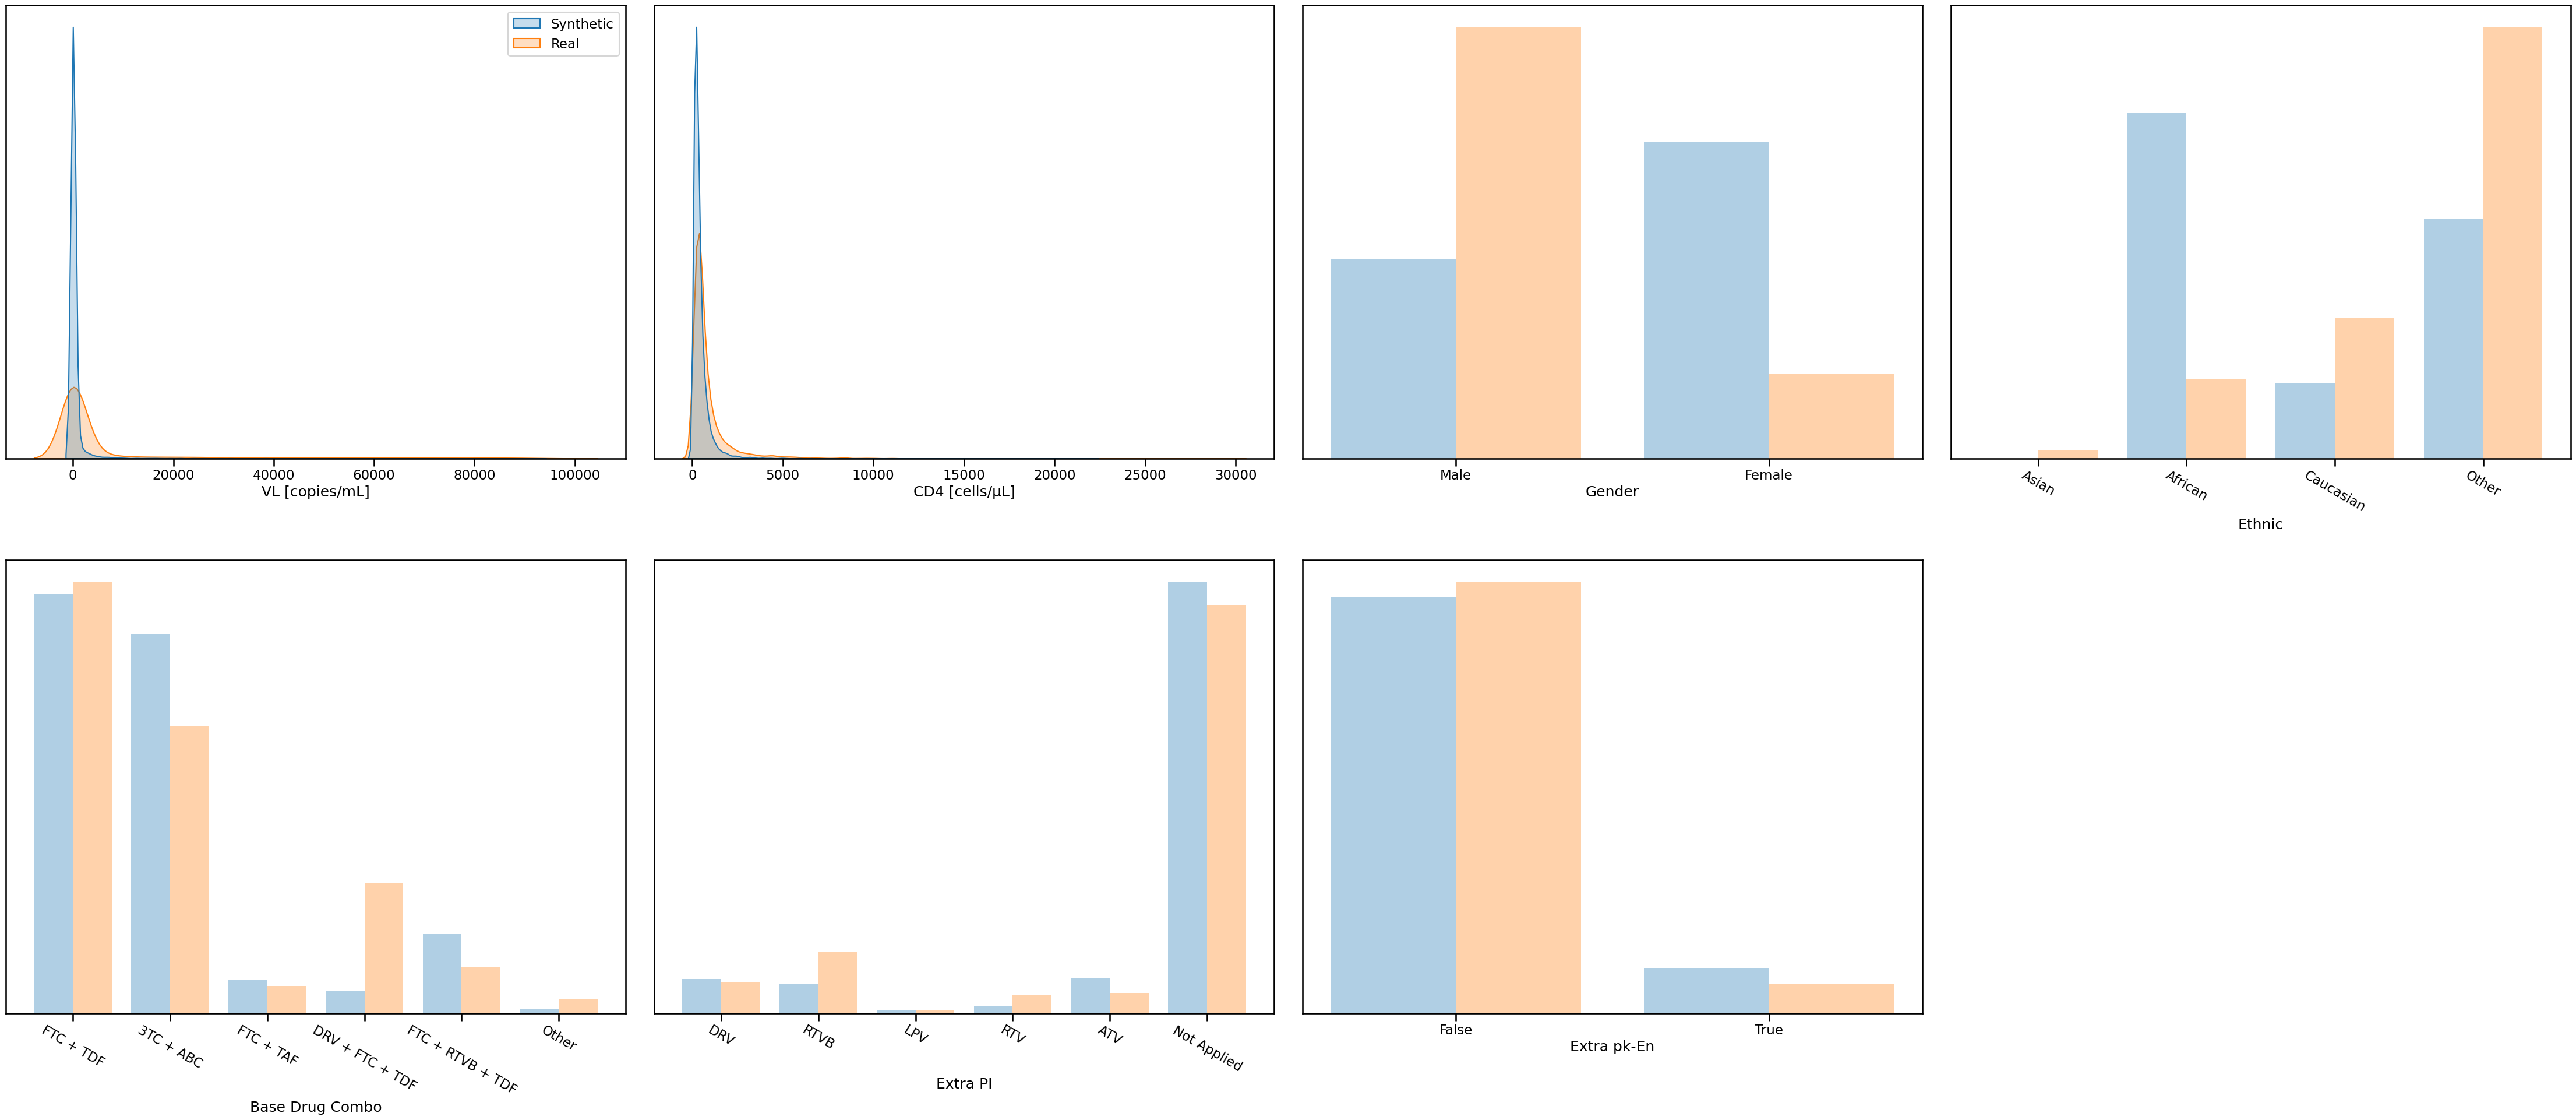

In [20]:
seed_all()

# ===========================
# Comparison plot
# ===========================
# Inputs expected:
# - Sub_Data : real dataframe (has snake_case cols)
# - df_fake  : synthetic dataframe (same snake_case cols)

sns.set_context("talk")
plt.rcParams.update({"font.size": 35, "legend.loc": "upper right"})

# 1) Align columns and labels (snake_case → pretty)
pretty_labels, internal_names = Execute_C008()

# sanity: make sure both frames have needed snake_case columns
missing_real = [c for c in internal_names if c not in Sub_Data.columns]
missing_fake = [c for c in internal_names if c not in df_fake.columns]
if missing_real:
    # can safely ignore PatientID/Timestep—they're not in INTERNAL_COLS
    raise KeyError(f"Missing in Sub_Data: {missing_real}")
if missing_fake:
    raise KeyError(f"Missing in df_fake: {missing_fake}")

Real_Data = Sub_Data[internal_names].copy()
Fake_Data = df_fake[internal_names].copy()

# 2) Grid
n_features = len(pretty_labels)
ncols = 4
nrows = (n_features + ncols - 1) // ncols
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(45, 10 * nrows))
axes = np.atleast_2d(axes)

# 3) Plot per feature
for k, pretty in enumerate(pretty_labels):
    i, j = divmod(k, ncols)
    ax = axes[i, j]
    internal = internal_names[k]

    cur_fake = Fake_Data[internal].to_numpy()
    cur_real = Real_Data[internal].to_numpy()

    if pretty in REAL_NAMES:
        df_all = make_df(pretty, cur_real, cur_fake, categorical=False)
        sns.kdeplot(
            data=df_all, x=pretty, hue="Type",
            fill=True, common_norm=False, ax=ax, legend=(k == 0)
        )
        if ax.legend_:
            ax.legend_.set_title(None)
        ax.yaxis.set_visible(False)
        ax.set_xlabel(pretty)
    else:
        df_all = make_df(pretty, cur_real, cur_fake, categorical=True)
        sns.histplot(
            data=df_all, x=pretty, hue="Type",
            multiple="dodge", stat="probability", shrink=0.8,
            alpha=0.35, linewidth=0, ax=ax, legend=False, discrete=True
        )
        if pretty in CATEGORY_LABELS and len(CATEGORY_LABELS[pretty]) > 3:
            ax.tick_params(axis="x", rotation=-30)
        ax.yaxis.set_visible(False)
        ax.set_xlabel(pretty)

# 4) Hide unused panels
for k in range(n_features, nrows * ncols):
    i, j = divmod(k, ncols)
    axes[i, j].axis("off")

plt.tight_layout(pad=1.0)
plt.show()
